In [1]:
%load_ext autoreload
%autoreload 2

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pydrake.solvers.mathematicalprogram as mp
import mpc.mpc_tools as mpc
import itertools

In [120]:
m = 1.
l = 1.
g = 10.
A = np.array([
    [0., 1.],
    [g/l, 0.]
])
B = np.array([
    [0.],
    [1/(m*l**2.)]
])
N = 5
t_s = .1
sys = mpc.DTLinearSystem.from_continuous(t_s, A, B)

x_max = np.array([[np.pi/6.],[np.pi/22./(N*t_s)]])
x_min = -x_max
u_max = np.array([[m*g*l*np.pi/8.]])
u_min = -u_max

Q = np.eye(A.shape[0])/100.
R = np.eye(B.shape[1])

In [181]:
N = 5
dim = 2

prog = mp.MathematicalProgram()

x = prog.NewContinuousVariables(2, N, "x")
u = prog.NewContinuousVariables(1, N, "u")

for j in range(N - 1):
    x_next = sys.A.dot(x[:, j]) + sys.B.dot(u[:, j])
    for i in range(dim):
        prog.AddLinearConstraint(x[i, j + 1] == x_next[i])
        
for j in range(N):
    for i in range(x.shape[0]):
        prog.AddLinearConstraint(x[i, j] <= x_max[i])
        prog.AddLinearConstraint(x[i, j] >= x_min[i])
    for i in range(u.shape[0]):
        prog.AddLinearConstraint(u[i, j] <= u_max[i])
        prog.AddLinearConstraint(u[i, j] >= u_min[i])
        
for j in range(N):
    prog.AddQuadraticCost(x[:, j].T.dot(Q).dot(x[:, j]))
    prog.AddQuadraticCost(u[:, j].T.dot(R).dot(u[:, j]))

In [182]:
def extract_linear_equalities(prog):
    bindings = prog.linear_equality_constraints()
    C = np.zeros((len(bindings), prog.num_vars()))
    d = np.zeros(len(bindings))
    for (i, binding) in enumerate(bindings):
        constraint = binding.constraint()
        ci = np.zeros(prog.num_vars())
        assert constraint.upper_bound() == constraint.lower_bound()
        d[i] = constraint.upper_bound()
        ai = constraint.A()
        assert ai.shape[0] == 1
        ai = ai[0, :]
        for (j, var) in enumerate(binding.variables()):
            ci[prog.FindDecisionVariableIndex(var)] = ai[j]
        C[i, :] = ci
    return C, d
    

def extract_linear_inequalities(prog):
    bindings = itertools.chain(prog.linear_constraints(), prog.bounding_box_constraints())
    if not bindings:
        return np.zeros((0, prog.num_vars())), np.zeros(0)
    A = []
    b = []
    for (i, binding) in enumerate(bindings):
        constraint = binding.constraint()
        A_row = np.zeros(prog.num_vars())
        ai = constraint.A()
        assert ai.shape[0] == 1
        ai = ai[0, :]
        for (j, var) in enumerate(binding.variables()):
            A_row[prog.FindDecisionVariableIndex(var)] = ai[j]
        
        if constraint.upper_bound() != np.inf:
            A.append(A_row)
            b.append(constraint.upper_bound())
        if constraint.lower_bound() != -np.inf:
            A.append(-A_row)
            b.append(-constraint.lower_bound())
    return np.vstack(A), np.hstack(b)
    

def mpc_order(prog, u, x0):
    order = np.zeros(prog.num_vars())
    order[:] = np.inf
    for (i, var) in enumerate(itertools.chain(u.flat, x0.flat)):
        order[prog.FindDecisionVariableIndex(var)] = i
    return np.argsort(order)
    

def simplify(C):
    C = C.copy()
    num_vars = C.shape[1]
    D = np.eye(num_vars)
    for j in range(C.shape[1] - 1, C.shape[1] - C.shape[0] - 1, -1):
        nonzeros = np.nonzero(C[:, j])[0]
        assert len(nonzeros) == 1
        i = nonzeros[0]
        v = C[i, :j] / -C[i, j]
        D = D.dot(np.vstack([np.eye(j), v]))
        C = C[[k for k in range(C.shape[0]) if k != i], :]
    return D


def extract_objective(prog):
    num_vars = prog.num_vars()
    Q = np.zeros((num_vars, num_vars))
    q = np.zeros(num_vars)
    
    for binding in prog.linear_costs():
        var_order = [prog.FindDecisionVariableIndex(v) for v in binding.variables()]
        ai = binding.constraint().A()
        assert ai.shape[0] == 1
        ai = ai[0, :]
        for i in range(ai.size):
            q[var_order[i]] += ai[i]
    
    for binding in prog.quadratic_costs():
        var_order = [prog.FindDecisionVariableIndex(v) for v in binding.variables()]
        Qi = binding.constraint().Q()
        bi = binding.constraint().b()
        for i in range(bi.size):
            q[var_order[i]] += bi[i]
            for j in range(bi.size):
                Q[var_order[i], var_order[j]] += Qi[i, j]
    Q = 0.5 * (Q + Q.T)
    return Q, q

def permutation_matrix(order):
    """
    Returns a matrix P such that P * y = y[order]
    """
    P = np.zeros((len(order), len(order)))
    for i in range(len(order)):
        P[i, order[i]] = 1
        
    return P

In [222]:
def generate_mpc_system(prog, u, x0):
    C, d = extract_linear_equalities(prog)
    A, b = extract_linear_inequalities(prog)
    Q, q = extract_objective(prog)
    assert np.allclose(q, 0), "linear objective terms are not yet implemented"
    return Q, q, A, b, C, d
    
    order = mpc_order(prog, u, x0)
    P = permutation_matrix(order)
    # yhat = P * y
    # y = P^-1 * yhat
    
    Pinv = np.linalg.inv(P)
    
    Qhat = Pinv.T.dot(Q).dot(Pinv)
    qhat = q.dot(Pinv)
    Ahat = A.dot(Pinv)
    bhat = b
    Chat = C.dot(Pinv)
    dhat = d
    
    for i in range(10):
        f = rand(q.size)
        fhat = f.dot(Pinv)
        y, cost = mpc.quadratic_program(Q, f, A, b, C, d)
        yhat, cost_hat = mpc.quadratic_program(Qhat, fhat, Ahat, bhat, Chat, dhat)
        assert np.isclose(cost, cost_hat)
        assert np.allclose(yhat, P.dot(y))
    
    W = simplify(Chat)
    # yhat = W * z
    
    Qtilde = W.T.dot(Qhat).dot(W)
    qtilde = qhat.dot(W)
    Atilde = Ahat.dot(W)
    btilde = bhat
    Ctilde = Chat.dot(W)
    dtilde = dhat
    assert np.allclose(Ctilde, 0)
    
    for i in range(100):
        f = rand(q.size)
        fhat = f.dot(Pinv)
        ftilde = fhat.dot(W)
        y, cost = mpc.quadratic_program(Q, f, A, b, C, d)
        yhat, cost_hat = mpc.quadratic_program(Qhat, fhat, Ahat, bhat, Chat, dhat)
        ytilde, cost_tilde = mpc.quadratic_program(Qtilde, ftilde, Atilde, btilde)
        assert np.isclose(cost, cost_hat)
        assert np.isclose(cost, cost_tilde)
        assert np.allclose(yhat, P.dot(y))
        assert np.allclose(yhat, W.dot(ytilde))
        
    H = Qtilde[:u.size, :u.size]
    F = Qtilde[u.size:, :u.size]
    G = Atilde[:, :u.size]
    E = -Atilde[:, u.size:]
    W = btilde
    
    return H, F, G, W, E

In [223]:
Q, q, A, b, C, d = generate_mpc_system(prog, u, x[:, 0])

In [224]:
prog.AddLinearCost(np.sum(u) + np.sum(x))

In [225]:
prog.Solve()

SolutionResult.kSolutionFound

In [228]:
prog.GetSolution(x)

array([[ 0.09522369,  0.06845627,  0.04374741,  0.01903279, -0.00774039],
       [-0.28559933, -0.25420288, -0.24408559, -0.25431913, -0.28559933]])

In [226]:
prog.GetSolution(u)

array([[-0.5018233 , -0.45900387, -0.41708772, -0.3718664 , -0.5       ]])

In [227]:
mpc.quadratic_program(Q, np.ones(q.size), A, b, C, d)

[array([[ 0.09522369],
        [-0.28559933],
        [ 0.06845627],
        [-0.25420288],
        [ 0.04374741],
        [-0.24408559],
        [ 0.01903279],
        [-0.25431913],
        [-0.00774039],
        [-0.28559933],
        [-0.5018233 ],
        [-0.45900387],
        [-0.41708772],
        [-0.3718664 ],
        [-0.5       ]]), array([[-2.32642883]])]

In [220]:
H, F, G, W, E = generate_mpc_system(prog, u, x[:, 0])

In [196]:
G.shape

(30, 5)

In [6]:
a = 0.1
b = 0.2
A = np.array([[b, 0, a, -1, 0], [0, b, 0, a, -1]])

In [7]:
simplify(A)

array([[ 1.  ,  0.  ,  0.  ],
       [ 0.  ,  1.  ,  0.  ],
       [ 0.  ,  0.  ,  1.  ],
       [ 0.2 ,  0.  ,  0.1 ],
       [ 0.02,  0.2 ,  0.01]])

array([[-0.00504181,  0.        ,  0.        ,  0.        ,  0.        ,
        -1.05041806, -0.10167502,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.10167502,  0.        ,  0.        ,  0.        ,  0.        ,
        -1.0167502 , -1.05041806,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.00504181,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -1.05041806, -0.10167502,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.10167502,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -1.0167502 , -1.05041806,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.00504181,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , 

In [20]:
simplify(C)

array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00

In [10]:
binding.variables()

array([u(0,3), x(0,3), x(1,3), x(1,4)], dtype=object)

In [11]:
binding.constraint().A()

array([[-0.10167502, -1.0167502 , -1.05041806,  1.        ]])

In [86]:
for binding in prog.linear_equality_constraints():
    print binding.variables()
    last_x = max(binding.variables(), key=lambda v: prog.FindDecisionVariableIndex(v))
    print last_x

[u(0,0) x(0,0) x(1,0) x(0,1)]
x(0,1)
[u(0,0) x(0,0) x(1,0) x(1,1)]
x(1,1)
[u(0,1) x(0,1) x(1,1) x(0,2)]
x(0,2)
[u(0,1) x(0,1) x(1,1) x(1,2)]
x(1,2)
[u(0,2) x(0,2) x(1,2) x(0,3)]
x(0,3)
[u(0,2) x(0,2) x(1,2) x(1,3)]
x(1,3)
[u(0,3) x(0,3) x(1,3) x(0,4)]
x(0,4)
[u(0,3) x(0,3) x(1,3) x(1,4)]
x(1,4)


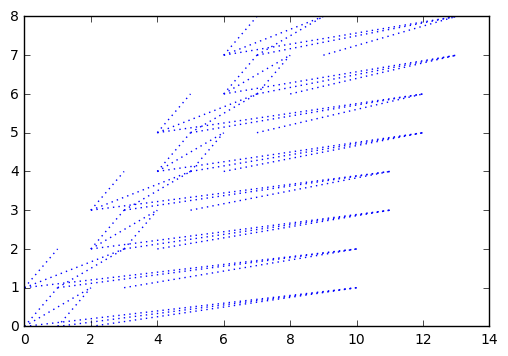

In [15]:
figure()
hold(True)
for (j, binding) in enumerate(prog.linear_equality_constraints()):
    
    for (v1, v2) in itertools.combinations(binding.variables(), 2):
        i1 = prog.FindDecisionVariableIndex(v1)
        i2 = prog.FindDecisionVariableIndex(v2)
        plot([i1, i2], [j, j+1], 'b:')
        